In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# BIWI head pose dataset 回归任务
- 数据集的每个图片中有一个点，这个点代表脸部的中间位置
- 我们试图创建模型来找到这个中心点

In [2]:
from fastai.vision import *
from fastai.utils.mem import *

## 数据获取

In [3]:
root = untar_data(URLs.BIWI_HEAD_POSE)
root

PosixPath('/home/lyc/.fastai/data/biwi_head_pose')

In [4]:
cal = np.genfromtxt(root/'01'/'rgb.cal', skip_footer=6)
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

- 随机看一下数据

In [5]:
fname = root/'09/frame_00667_rgb.jpg'

- 原始图像

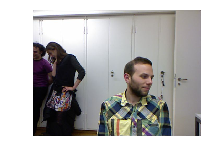

In [6]:
img = open_image(fn=fname)
img.show()

- 获取标签

In [7]:
def img2txt_name(f):
    return root/f'{fname.as_posix()[:-7]}pose.txt'

In [8]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3)
ctr

array([187.332 ,  40.3892, 893.135 ])

- 函数化

In [9]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img, pts):
    return ImagePoints(FlowField(img.size, pts), scale=True)

- 获取坐标

In [10]:
ctr = get_ctr(fname)
ctr

tensor([263.9104, 428.5814])

In [11]:
get_ip(img, ctr)

ImagePoints (480, 640)

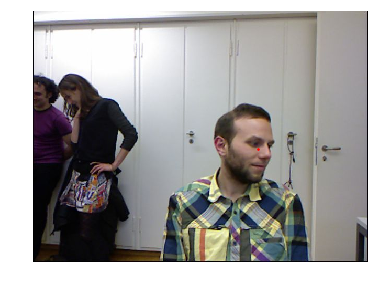

In [12]:
img.show(y=get_ip(img, ctr), figsize=(6, 6))

- 通过上述的过程大致理清整个流程，下面创建数据

## 数据

In [13]:
root.parent.name

'data'

- X,y 要同时变换
- 原始图像 480*640 这里放缩为 120*160

In [14]:
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 4096:
    bs=32
else:
    bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=32, have 6149MB of GPU RAM free


In [15]:
# tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)
tfms = get_transforms()

In [16]:
sz = img.shape[1:]
sz

torch.Size([480, 640])

In [17]:
data = (PointsItemList.from_folder(root)
        .split_by_valid_func(lambda o: o.parent.name=='11')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=[120, 160])
        .databunch(bs=bs)
        .normalize(imagenet_stats)
       )

- 默认的 batchsize 是 64

In [18]:
data

ImageDataBunch;

Train: LabelList (15106 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /home/lyc/.fastai/data/biwi_head_pose;

Valid: LabelList (572 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /home/lyc/.fastai/data/biwi_head_pose;

Test: None

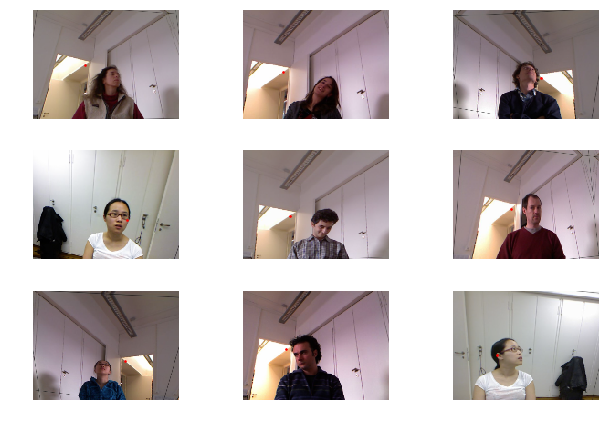

In [19]:
data.show_batch(rows=3, figsize=(9, 6))

## 模型构建

In [20]:
arch = models.resnet34

In [21]:
learn = cnn_learner(data, arch, metrics=mse)

In [22]:
doc(mse)

mean_squared_error [source] [test] mean_squared_error ( pred : Tensor , targ : Tensor ) → Rank0Tensor 
 
 × Tests found for mean_squared_error : pytest -sv tests/test_metrics.py::test_mse [source] To run tests please refer to this guide . Mean squared error between pred and targ . 
 Show in docs

In [23]:
learn.loss_func

FlattenedLoss of MSELoss()

- 学习率

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


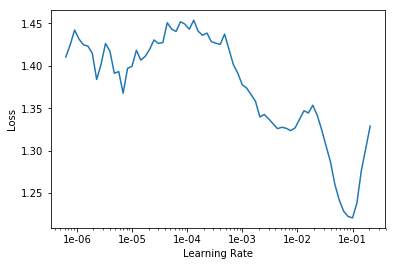

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
lr1 = 3e-2

In [26]:
learn.fit_one_cycle(5, slice(lr1))

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.035073,0.004041,0.004041,01:20
1,0.013818,0.006560,0.006560,01:17
2,0.012154,0.019895,0.019895,01:14
3,0.004846,0.000275,0.000275,01:16
4,0.003376,0.000147,0.000147,01:33


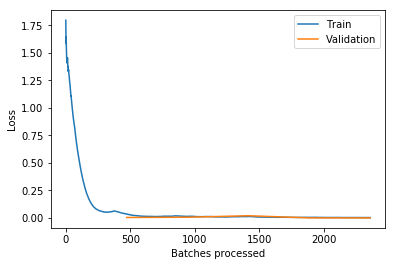

In [27]:
learn.recorder.plot_losses()

- 保存

In [28]:
learn.save('stage1-resnet34')

- stage 2

In [29]:
learn.load('stage1-resnet34');

In [30]:
learn.unfreeze()

- 再次寻找学习率

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


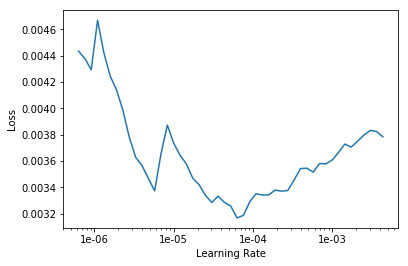

In [31]:
learn.lr_find()
learn.recorder.plot()

In [38]:
lr2 = 1e-5

In [39]:
learn.fit_one_cycle(3, slice(lr2, lr1/5))

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.004317,0.000424,0.000424,03:20
1,0.003809,0.000419,0.000419,03:24
2,0.002662,0.000537,0.000537,01:23


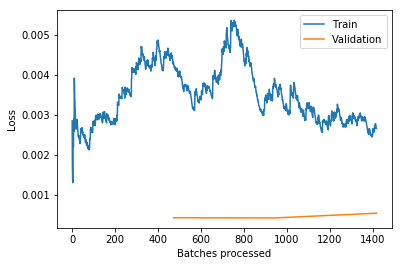

In [40]:
learn.recorder.plot_losses()

In [41]:
learn.save('stage2-resnet34')

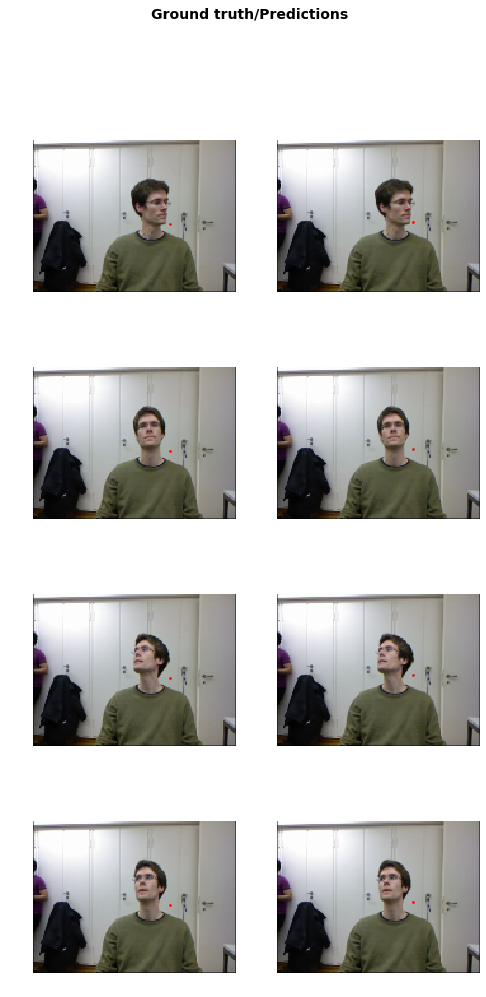

In [42]:
learn.show_results(rows=4)

In [37]:
learn

Learner(data=ImageDataBunch;

Train: LabelList (15106 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /home/lyc/.fastai/data/biwi_head_pose;

Valid: LabelList (572 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /home/lyc/.fastai/data/biwi_head_pose;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, 